# DDSIM vs Qiskit Aer

In [1]:
import time
import random

import matplotlib.pyplot as plt
from mqt import ddsim
import numpy as np
import qiskit
import qiskit_aer

## One case

### Create the target circuits

In [2]:
num_state_qubits = 14
circuit = qiskit.circuit.library.DraperQFTAdder(num_state_qubits)

# ==========
a = 7
b = 5
# ==========
a_bin = bin(a)[2:]
b_bin = bin(b)[2:]
out_bin = bin(a + b)[2:]
print(f"a + b = {a} + {b} = {int(out_bin, 2)}")

for index, letter in enumerate(a_bin[::-1]):
    if letter == "1":
        circuit.compose(qiskit.circuit.library.XGate(), [index], front=True, inplace=True)
for index, letter in enumerate(b_bin[::-1], num_state_qubits):
    if letter == "1":
        circuit.compose(qiskit.circuit.library.XGate(), [index], front=True, inplace=True)

# circuit.draw()

a + b = 7 + 5 = 12


### Define utils

In [3]:
SEED = 901

In [4]:
def convert_counts(original_counts):
    return {int(value, 16): original_counts[value] for value in original_counts}

In [5]:
def get_transpiled(backend):
    pass_manager = qiskit.transpiler.generate_preset_pass_manager(
        optimization_level=3,
        backend=backend,
        seed_transpiler=SEED,
    )

    trainspiled_circuit = pass_manager.run(circuit)  # Use the circuit defined above

    trainspiled_circuit.add_register(qiskit.ClassicalRegister(circuit.num_qubits - circuit.num_state_qubits))
    trainspiled_circuit.measure(trainspiled_circuit.qregs[-1], trainspiled_circuit.cregs[0])
    
    return trainspiled_circuit

In [6]:
def run(backend):
    assert SEED == backend.options.seed_simulator
    transpiled_circuit = get_transpiled(backend)
    
    job = backend.run(transpiled_circuit, shots=8192)

    return job

### Check the backends

In [7]:
ddsim.DDSIMProvider().backends()

In [8]:
qiskit_aer.AerProvider().backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

### QASM

#### AerSimulator

In [9]:
aer_qasm = qiskit_aer.AerSimulator(seed_simulator=SEED)
aer_qasm_job = run(aer_qasm)

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit DraperQFTAdder using the statevector simulator. Required memory: 32768M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit DraperQFTAdder using the statevector simulator. Required memory: 32768M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit DraperQFTAdder using the statevector simulator. Required memory: 32768M, max memory: 16384M


In [10]:
print(aer_qasm_job.status())
print(convert_counts(aer_qasm_job.result().results[0].data.counts))
aer_qasm_job.result().results[0].metadata["time_taken"]

JobStatus.DONE
{12: 8192}


80.982655708

#### Among DDSIM

##### `QasmSimulatorBackend`

In [11]:
ddsim_qasm = ddsim.qasmsimulator.QasmSimulatorBackend()
ddsim_qasm.options.update_options(seed_simulator=SEED)

ddsim_qasm_job = run(ddsim_qasm)

In [12]:
print(ddsim_qasm_job.status())
print(convert_counts(ddsim_qasm_job.result().results[0].data.counts))
ddsim_qasm_job.result().results[0].data.time_taken

JobStatus.DONE
{12: 8192}


0.015814781188964844

##### `HybridQasmSimulatorBackend`
`MemoryError: std::bad_alloc` arises.

In [13]:
# ddsim_hybrid_qasm = ddsim.hybridqasmsimulator.HybridQasmSimulatorBackend()
# ddsim_hybrid_qasm.options.update_options(seed_simulator=SEED)
# 1
# ddsim_hybrid_qasm_job = run(ddsim_hybrid_qasm)

In [14]:
# print(convert_counts(ddsim_hybrid_qasm_job.result().results[0].data.counts))
# ddsim_qasm_job.result().results[0].data.time_taken

##### `PathQasmSimulatorBackend`
`MemoryError: std::bad_alloc` arises.

In [15]:
# ddsim_path_qasm = ddsim.pathqasmsimulator.PathQasmSimulatorBackend()
# ddsim_path_qasm.options.update_options(seed_simulator=SEED)

# ddsim_path_qasm_job = run(ddsim_hybrid_qasm)

In [16]:
# print(convert_counts(ddsim_path_qasm_job.result().results[0].data.counts))
# ddsim_path_qasm_job.result().results[0].data.time_taken

## Comprehensive Analysis

### Increase in the number of qubtis

In [17]:
def get_circuit(num_state_qubits, a, b):
    circuit = qiskit.circuit.library.DraperQFTAdder(num_state_qubits, kind='half')

    a_bin = bin(a)[2:]
    b_bin = bin(b)[2:]
    out_bin = bin(a + b)[2:]
    # print(f"a + b = {a} + {b} = {int(out_bin, 2)}")
    
    for index, letter in enumerate(a_bin[::-1]):
        if letter == "1":
            circuit.compose(qiskit.circuit.library.XGate(), [index], front=True, inplace=True)
    for index, letter in enumerate(b_bin[::-1], num_state_qubits):
        if letter == "1":
            circuit.compose(qiskit.circuit.library.XGate(), [index], front=True, inplace=True)

    return circuit

In [18]:
SEED = 901
SHOTS = 8192

def convert_counts(original_counts):
    return {int(value, 16): original_counts[value] for value in original_counts}

In [19]:
aer_qasm = qiskit_aer.AerSimulator(seed_simulator=SEED)

ddsim_qasm = ddsim.qasmsimulator.QasmSimulatorBackend()
ddsim_qasm.options.update_options(seed_simulator=SEED)

In [20]:
%%time
random.seed(SEED)

max_num_state_qubits = 15
num_trials = 3

aer_jobs = dict()
ddsim_jobs = dict()
for num_state_qubits in range(1, max_num_state_qubits+1):
    for _ in range(num_trials):
        max_number = (2 ** num_state_qubits) - 1
        a = random.randint(0, max_number)
        b = random.randint(0, max_number)
        
        # Get the target circuit.
        circuit = get_circuit(num_state_qubits, a, b)
        
        # Make the key for the dicts.
        result = a + b
        key = (circuit.num_qubits, num_trials, a, b, result)
    
        # Transpile the circuit for Aer.
        pass_manager = qiskit.transpiler.generate_preset_pass_manager(
            optimization_level=3,
            backend=aer_qasm,
            seed_transpiler=SEED,
        )
        trainspiled_circuit_for_aer = pass_manager.run(circuit)
        trainspiled_circuit_for_aer.add_register(
            qiskit.ClassicalRegister(circuit.num_qubits - circuit.num_state_qubits)
        )
        for c_index in range(trainspiled_circuit_for_aer.num_qubits - num_state_qubits):
            q_index = c_index + num_state_qubits
            trainspiled_circuit_for_aer.measure(q_index, c_index)
        # Run the circuit with Aer.
        job = aer_qasm.run(trainspiled_circuit_for_aer, shots=SHOTS)
        
        aer_jobs[key] = job
    
        # Transpile the circuit for DDSIM.
        pass_manager = qiskit.transpiler.generate_preset_pass_manager(
            optimization_level=3,
            backend=ddsim_qasm,
            seed_transpiler=SEED,
        )
        trainspiled_circuit_for_ddsim = pass_manager.run(circuit)
        trainspiled_circuit_for_ddsim.add_register(
            qiskit.ClassicalRegister(circuit.num_qubits - circuit.num_state_qubits)
        )
        for c_index in range(trainspiled_circuit_for_aer.num_qubits - num_state_qubits):
            q_index = c_index + num_state_qubits
            trainspiled_circuit_for_ddsim.measure(q_index, c_index)
        # Run the circuit with DDSIM.
        job = ddsim_qasm.run(trainspiled_circuit_for_ddsim, shots=SHOTS)
        ddsim_jobs[key] = job

CPU times: user 1h 13min 28s, sys: 11min 8s, total: 1h 24min 37s
Wall time: 17min 16s


In [21]:
# Define functions to organise data.
def get_success_possibility(job, true_key_digit, shots=SHOTS):
    counts_digit = convert_counts(job.result().results[0].data.counts)
    return counts_digit[true_key_digit] / shots

def get_time_taken_from_aer(job):
    return job.result().results[0].metadata["time_taken"]

def get_time_taken_from_ddsim(job):
    return job.result().results[0].data.time_taken

In [22]:
# Organise the data for Aer.
aer_results = dict()
for key, aer_job in aer_jobs.items():
    num_qubits = key[0]
    if num_qubits not in aer_results:
        aer_results[num_qubits] = {"success_possibilities": [], "time_taken": []}

    if not aer_job.result().results[0].success:
        continue
    true_key_digit = key[-1]
    aer_results[num_qubits]["success_possibilities"].append(get_success_possibility(aer_job, true_key_digit))
    aer_results[num_qubits]["time_taken"].append(get_time_taken_from_aer(aer_job))

aer_result = [
    (num_qubits,
     float(np.mean(aer_results[num_qubits]["success_possibilities"])),
     float(np.mean(aer_results[num_qubits]["time_taken"])),
    )
    for num_qubits in aer_results.keys()
]
aer_result

/Users/ksk/.pyenv/versions/3.13.2/envs/backend_comparison/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ksk/.pyenv/versions/3.13.2/envs/backend_comparison/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[(3, 1.0, 0.0048243545),
 (5, 1.0, 0.006026458),
 (7, 1.0, 0.006935041666666667),
 (9, 1.0, 0.017609791333333333),
 (11, 1.0, 0.021586694333333333),
 (13, 1.0, 0.025509930333333333),
 (15, 1.0, 0.017842486333333334),
 (17, 1.0, 0.028705833666666666),
 (19, 1.0, 0.10466601399999999),
 (21, 1.0, 0.4955295),
 (23, 1.0, 2.2340308613333333),
 (25, 1.0, 9.841457389),
 (27, 1.0, 41.442386750333334),
 (29, 1.0, 287.76303001366665),
 (31, nan, nan)]

In [23]:
# Organise the data for DDSIM.
ddsim_results = dict()
for key, ddsim_job in ddsim_jobs.items():
    num_qubits = key[0]
    if num_qubits not in ddsim_results:
        ddsim_results[num_qubits] = {"success_possibilities": [], "time_taken": []}

    if not ddsim_job.result().results[0].success:
        continue
    
    true_key_digit = key[-1]
    ddsim_results[num_qubits]["success_possibilities"].append(get_success_possibility(ddsim_job, true_key_digit))
    ddsim_results[num_qubits]["time_taken"].append(get_time_taken_from_ddsim(ddsim_job))

ddsim_result = [
    (num_qubits,
     float(np.mean(ddsim_results[num_qubits]["success_possibilities"])),
     float(np.mean(ddsim_results[num_qubits]["time_taken"])),
    )
    for num_qubits in ddsim_results.keys()
]
ddsim_result

[(3, 1.0, 0.005348563194274902),
 (5, 1.0, 0.004994988441467285),
 (7, 1.0, 0.006453116734822591),
 (9, 1.0, 0.010559002558390299),
 (11, 1.0, 0.010590076446533203),
 (13, 1.0, 0.01467744509379069),
 (15, 1.0, 0.015854358673095703),
 (17, 1.0, 0.014838377634684244),
 (19, 1.0, 0.017535686492919922),
 (21, 1.0, 0.020144144694010418),
 (23, 1.0, 0.024961551030476887),
 (25, 1.0, 0.026864051818847656),
 (27, 1.0, 0.022557973861694336),
 (29, 1.0, 0.0401456356048584),
 (31, 1.0, 0.027736425399780273)]

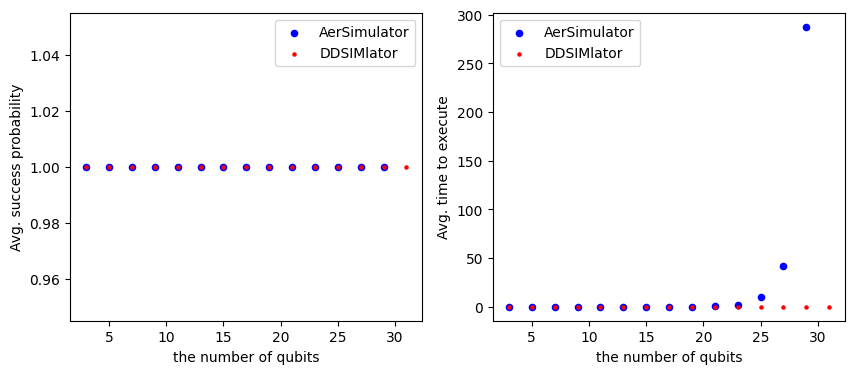

In [24]:
assert [num_qubits  for num_qubits, _, _ in aer_result] == [num_qubits  for num_qubits, _, _ in ddsim_result]
x = [num_qubits  for num_qubits, _, _ in aer_result]
success_possibilities_aer = [success_possibility  for _, success_possibility, _ in aer_result]
success_possibilities_ddsim = [success_possibility  for _, success_possibility, _ in ddsim_result]
times_taken_aer = [time_taken  for _, _, time_taken in aer_result]
times_taken_ddsim = [time_taken  for _, _, time_taken in ddsim_result]

fig, axes = plt.subplots(ncols=2, figsize=(10,4))

# Success probability
axes[0].scatter(x, success_possibilities_aer, color="blue", s=20, label="AerSimulator")
axes[0].scatter(x, success_possibilities_ddsim, color="red", s=5, label="DDSIMlator")
axes[0].set_xlabel("the number of qubits")
axes[0].set_ylabel("Avg. success probability")
axes[0].legend()

# Time taken
axes[1].scatter(x, times_taken_aer, color="blue", s=20, label="AerSimulator")
axes[1].scatter(x, times_taken_ddsim, color="red", s=5, label="DDSIMlator")
axes[1].set_xlabel("the number of qubits")
axes[1].set_ylabel("Avg. time to execute")
axes[1].legend()

plt.savefig("ddsim_vs_aer_qubits.png")

plt.show()

### Increase in the number of adder

In [25]:
def get_deep_circuit(num_state_qubits, a, b, depth):
    if depth <= 0:
        depth = 1

    circuit = qiskit.circuit.library.DraperQFTAdder(num_state_qubits, kind='half')

    a_bin = bin(a)[2:]
    b_bin = bin(b)[2:]
    out_bin = bin(a + b)[2:]
    # print(f"a + b = {a} + {b} = {int(out_bin, 2)}")
    
    for index, letter in enumerate(a_bin[::-1]):
        if letter == "1":
            circuit.compose(qiskit.circuit.library.XGate(), [index], front=True, inplace=True)
    for index, letter in enumerate(b_bin[::-1], num_state_qubits):
        if letter == "1":
            circuit.compose(qiskit.circuit.library.XGate(), [index], front=True, inplace=True)

    for _ in range(depth - 1):
        circuit.compose(qiskit.circuit.library.DraperQFTAdder(num_state_qubits, kind='half'), range(circuit.num_qubits), inplace=True)

    return circuit

In [26]:
%%time
random.seed(SEED)

num_state_qubits = 10
max_depth = 20
num_trials = 3

aer_jobs = dict()
ddsim_jobs = dict()
for depth in range(1, max_depth + 1):
    for _ in range(num_trials):
        max_number = (2 ** num_state_qubits) - 1
        a = random.randint(0, max_number)
        b = random.randint(0, max_number)
        
        # Get the target circuit.
        circuit = get_deep_circuit(num_state_qubits, a, b, depth)
        
        # Make the key for the dicts.
        result = (a * depth + b) % (2 ** (num_state_qubits + 1))
        key = (depth, num_trials, a, b, result)
    
        # Transpile the circuit for Aer.
        pass_manager = qiskit.transpiler.generate_preset_pass_manager(
            optimization_level=3,
            backend=aer_qasm,
            seed_transpiler=SEED,
        )
        trainspiled_circuit_for_aer = pass_manager.run(circuit)
        trainspiled_circuit_for_aer.add_register(
            qiskit.ClassicalRegister(circuit.num_qubits - circuit.num_state_qubits)
        )
        for c_index in range(trainspiled_circuit_for_aer.num_qubits - num_state_qubits):
            q_index = c_index + num_state_qubits
            trainspiled_circuit_for_aer.measure(q_index, c_index)
        # Run the circuit with Aer.
        job = aer_qasm.run(trainspiled_circuit_for_aer, shots=SHOTS)
        
        aer_jobs[key] = job
    
        # Transpile the circuit for DDSIM.
        pass_manager = qiskit.transpiler.generate_preset_pass_manager(
            optimization_level=3,
            backend=ddsim_qasm,
            seed_transpiler=SEED,
        )
        trainspiled_circuit_for_ddsim = pass_manager.run(circuit)
        trainspiled_circuit_for_ddsim.add_register(
            qiskit.ClassicalRegister(circuit.num_qubits - circuit.num_state_qubits)
        )
        for c_index in range(trainspiled_circuit_for_aer.num_qubits - num_state_qubits):
            q_index = c_index + num_state_qubits
            trainspiled_circuit_for_ddsim.measure(q_index, c_index)
        # Run the circuit with DDSIM.
        job = ddsim_qasm.run(trainspiled_circuit_for_ddsim, shots=SHOTS)
        ddsim_jobs[key] = job

CPU times: user 28min 6s, sys: 3min 27s, total: 31min 34s
Wall time: 9min 37s


In [27]:
# Organise the data for Aer.
aer_results = dict()
for key, aer_job in aer_jobs.items():
    num_qubits = key[0]
    if num_qubits not in aer_results:
        aer_results[num_qubits] = {"success_possibilities": [], "time_taken": []}

    if not aer_job.result().results[0].success:
        continue

    true_key_digit = key[-1]
    aer_results[num_qubits]["success_possibilities"].append(get_success_possibility(aer_job, true_key_digit))
    aer_results[num_qubits]["time_taken"].append(get_time_taken_from_aer(aer_job))

aer_result = [
    (num_qubits,
     float(np.mean(aer_results[num_qubits]["success_possibilities"])),
     float(np.mean(aer_results[num_qubits]["time_taken"])),
    )
    for num_qubits in aer_results.keys()
]
aer_result

[(1, 1.0, 0.9007825),
 (2, 1.0, 1.6567884723333333),
 (3, 1.0, 2.414385472333333),
 (4, 1.0, 3.254528528333333),
 (5, 1.0, 3.921813416333334),
 (6, 1.0, 4.719968555333334),
 (7, 1.0, 5.529696347333332),
 (8, 1.0, 6.371555139000001),
 (9, 1.0, 7.312892902999999),
 (10, 1.0, 8.184012569333333),
 (11, 1.0, 8.606600499999999),
 (12, 1.0, 9.507874361),
 (13, 1.0, 10.193937486000001),
 (14, 1.0, 11.019931249999999),
 (15, 1.0, 12.837036235999998),
 (16, 1.0, 13.088461653333335),
 (17, 1.0, 14.018562041000001),
 (18, 1.0, 14.629631263999999),
 (19, 1.0, 15.555074),
 (20, 1.0, 16.171442014333334)]

In [28]:
# Organise the data for DDSIM.
ddsim_results = dict()
for key, ddsim_job in ddsim_jobs.items():
    num_qubits = key[0]
    if num_qubits not in ddsim_results:
        ddsim_results[num_qubits] = {"success_possibilities": [], "time_taken": []}

    if not ddsim_job.result().results[0].success:
        continue
    
    true_key_digit = key[-1]
    ddsim_results[num_qubits]["success_possibilities"].append(get_success_possibility(ddsim_job, true_key_digit))
    ddsim_results[num_qubits]["time_taken"].append(get_time_taken_from_ddsim(ddsim_job))

ddsim_result = [
    (num_qubits,
     float(np.mean(ddsim_results[num_qubits]["success_possibilities"])),
     float(np.mean(ddsim_results[num_qubits]["time_taken"])),
    )
    for num_qubits in ddsim_results.keys()
]
ddsim_result

[(1, 1.0, 0.025707403818766277),
 (2, 1.0, 0.026146650314331055),
 (3, 1.0, 0.030513842900594074),
 (4, 1.0, 0.030558347702026367),
 (5, 1.0, 0.03859210014343262),
 (6, 1.0, 0.04026548067728678),
 (7, 1.0, 0.04094990094502767),
 (8, 1.0, 0.037010749181111656),
 (9, 1.0, 0.03517810503641764),
 (10, 1.0, 0.03474752108256022),
 (11, 1.0, 0.04469490051269531),
 (12, 1.0, 0.04243906339009603),
 (13, 1.0, 0.03602719306945801),
 (14, 1.0, 0.035089731216430664),
 (15, 1.0, 0.03907966613769531),
 (16, 1.0, 0.0421753724416097),
 (17, 1.0, 0.038157145182291664),
 (18, 1.0, 0.04076735178629557),
 (19, 1.0, 0.041208744049072266),
 (20, 1.0, 0.038050572077433266)]

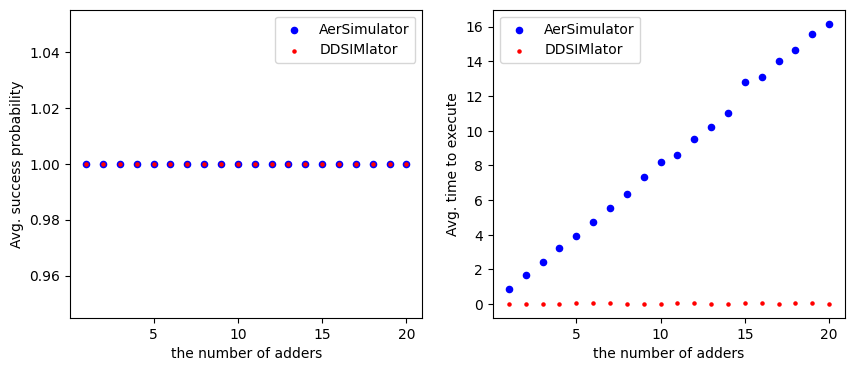

In [29]:
assert [num_qubits  for num_qubits, _, _ in aer_result] == [num_qubits  for num_qubits, _, _ in ddsim_result]
x = [num_qubits  for num_qubits, _, _ in aer_result]
success_possibilities_aer = [success_possibility  for _, success_possibility, _ in aer_result]
success_possibilities_ddsim = [success_possibility  for _, success_possibility, _ in ddsim_result]
times_taken_aer = [time_taken  for _, _, time_taken in aer_result]
times_taken_ddsim = [time_taken  for _, _, time_taken in ddsim_result]

fig, axes = plt.subplots(ncols=2, figsize=(10,4))

# Success probability
axes[0].scatter(x, success_possibilities_aer, color="blue", s=20, label="AerSimulator")
axes[0].scatter(x, success_possibilities_ddsim, color="red", s=5, label="DDSIMlator")
axes[0].set_xlabel("the number of adders")
axes[0].set_ylabel("Avg. success probability")
axes[0].legend()

# Time taken
axes[1].scatter(x, times_taken_aer, color="blue", s=20, label="AerSimulator")
axes[1].scatter(x, times_taken_ddsim, color="red", s=5, label="DDSIMlator")
axes[1].set_xlabel("the number of adders")
axes[1].set_ylabel("Avg. time to execute")
axes[1].legend()

plt.savefig("ddsim_vs_aer_gates.png")

plt.show()